<a href="https://colab.research.google.com/github/gorkemgok0/Portuguese-Student-Performance-ML/blob/main/Portuguese_Student_Performance_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [40]:
df=pd.read_csv('/content/student-por.csv')

In [41]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [43]:
#df['school'].value_counts()
#df['sex'].value_counts()
#df['address'].value_counts()
#df['famsize'].value_counts()
#df['Pstatus'].value_counts()
#df['Mjob'].value_counts()
#df['Fjob'].value_counts()
#df['reason'].value_counts()
#df['guardian'].value_counts()
#df['schoolsup'].value_counts()
#df['famsup'].value_counts()
#df['paid'].value_counts()
#df['activities'].value_counts()
#df['nursery'].value_counts()
#df['higher'].value_counts()
#df['internet'].value_counts()
#df['romantic'].value_counts()

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [45]:
onehot_cols = ["Mjob", "Fjob", "reason", "guardian"]
binary_cols = [
    "school", "sex", "address", "famsize", "Pstatus",
    "schoolsup", "famsup", "paid", "activities", "nursery",
    "higher", "internet", "romantic"
]

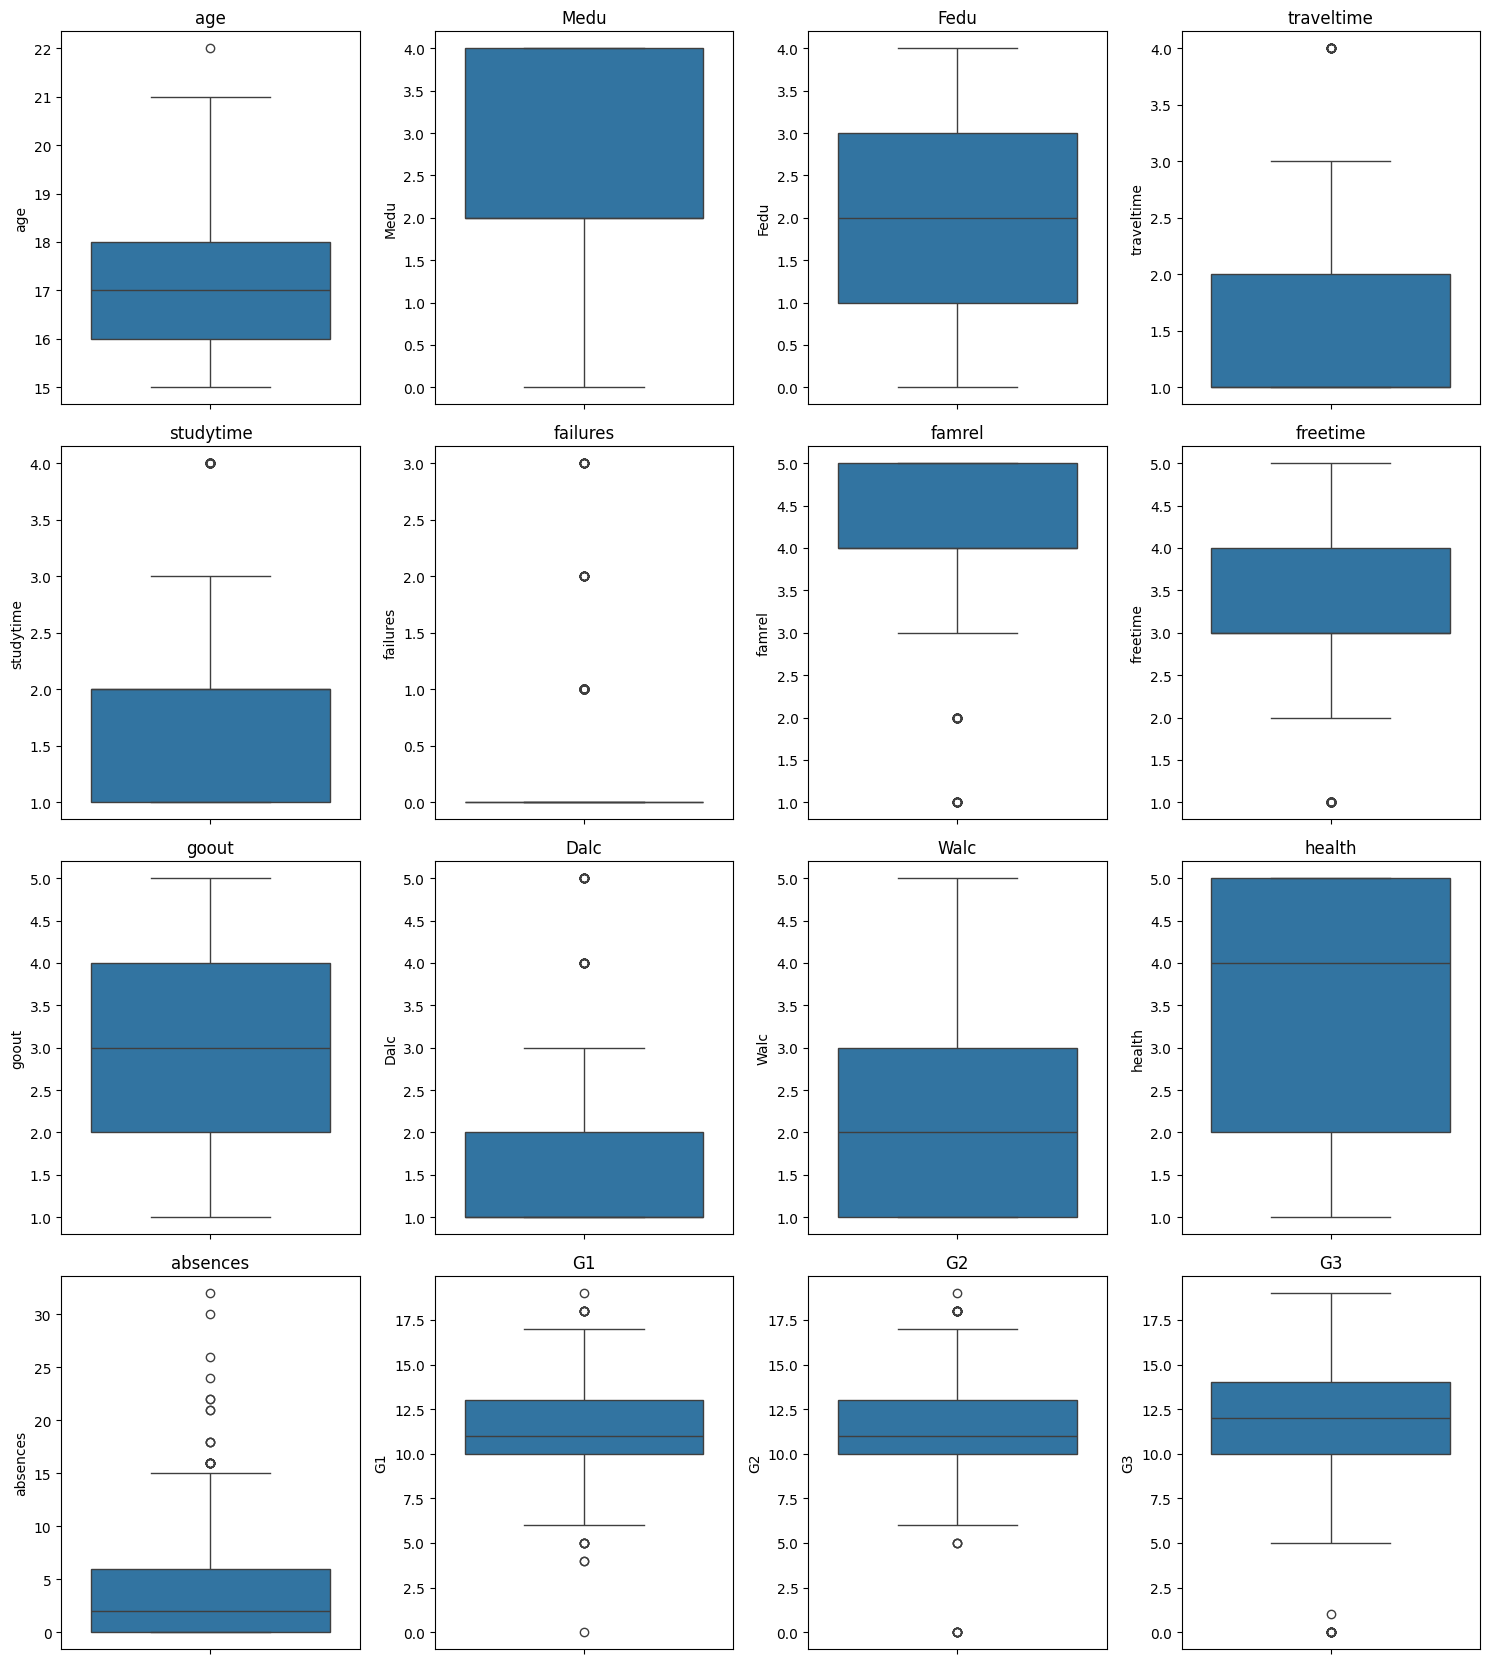

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 25)) # Increased figure size to accommodate more subplots
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(6, 4, i) # Increased the number of rows to 6
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [47]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)


In [48]:
for col in binary_cols:
    df[col] = df[col].map({"yes": 1, "no": 0,
                           "GP": 1, "MS": 0,
                           "F": 0, "M": 1,
                           "U": 1, "R": 0,
                           "LE3": 0, "GT3": 1,
                           "T": 1, "A": 0})

In [49]:
X = df.drop("G3", axis=1)   # Özellikler
y = df["G3"]                # Hedef: Final notu

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first"), onehot_cols)  # dummy trap için drop="first"
    ],
    remainder="passthrough"  # diğer sütunlar aynı kalsın
)


In [51]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [52]:
param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [5, 10, None],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4]
}


In [53]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="r2",   # regresyon R^2
    n_jobs=-1,
    verbose=1
)


In [54]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid.fit(X_train, y_train)

print("En iyi parametreler:", grid.best_params_)
print("Train R^2:", grid.score(X_train, y_train))
print("Test R^2:", grid.score(X_test, y_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
En iyi parametreler: {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Train R^2: 0.9304301421269094
Test R^2: 0.8938353161614939
